In [2]:
RANDOM_STATE = 1234

In [1]:
# CARGA DEL DATASET
# Voy a usar el mismo dataset de emociones que utilicé para la actividad anterior

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/EALC/"

emotion_file = path + "emotion.csv"

df = pd.read_csv(emotion_file)
df.head()

Mounted at /content/drive


,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [3]:
# realizo el mismo proceso de normalización que en la actividad anterior

# PREPROCESAMIENTO DEL DATASET
import re
import nltk
from nltk.corpus import stopwords

wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords') # añadido
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

# Crear una nueva columna 'review_normalized' en el DataFrame
df['comment_normalized'] = df['Comment'].apply(normalize_document)

# Verificar el DataFrame resultante
df.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Comment,Emotion,comment_normalized
0,i seriously hate one subject to death but now ...,fear,seriously hate one subject death feel reluctan...
1,im so full of life i feel appalled,anger,im full life feel appalled
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feelings think afraid acce...
3,ive been really angry with r and i feel like a...,joy,ive really angry r feel like idiot trusting fi...
4,i feel suspicious if there is no one outside l...,fear,feel suspicious one outside like rapture happe...
5,i feel jealous becasue i wanted that kind of l...,anger,feel jealous becasue wanted kind love true con...
6,when a friend of mine keeps telling me morbid ...,anger,friend mine keeps telling morbid things happen...
7,i finally fell asleep feeling angry useless an...,anger,finally fell asleep feeling angry useless stil...
8,i feel a bit annoyed and antsy in a good way,anger,feel bit annoyed antsy good way
9,i feel like i ve regained another vital part o...,joy,feel like regained another vital part life living


In [7]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# en la actividad anterior obtuve las palabras de media de cada texto (19)

max_words = 2500
max_comment_length = 19

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.comment_normalized)

sequences = tokenizer.texts_to_sequences(df.comment_normalized)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_words = len(word_index)

data = pad_sequences(sequences, maxlen=max_comment_length)

Found 8834 unique tokens.


In [16]:
for i in range(3):
    print(f"Index: {i+1}")
    print("Comment:")
    print(df.comment_normalized[i])
    print("\nData:")
    print(data[i])
    print("\nEmotion:")
    print(df.Emotion[i])
    print("\n" + "="*40 + "\n")

Index: 1
Comment:
seriously hate one subject death feel reluctant drop

Data:
[   0    0    0    0    0    0    0    0    0    0    0  534  160   16
 1238  838    1  123 1104]

Emotion:
fear


Index: 2
Comment:
im full life feel appalled

Data:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   4 387  26   1
 839]

Emotion:
anger


Index: 3
Comment:
sit write start dig feelings think afraid accept possibility might make

Data:
[   0    0    0    0    0    0    0    0  334   94  113 1987   49   14
   78  840 1105  135   25]

Emotion:
fear




In [32]:
from sklearn.model_selection import train_test_split

#valor de random state
rs= RANDOM_STATE

d=df.values

x_train, x_val, y_train, y_val = train_test_split(data, df.Emotion, test_size=0.20, random_state=rs, stratify = df.Emotion)

print("Training texts:", len(y_train))
print("Val texts:", len(y_val))
print("Training texts:", len(x_train))
print("Training texts:", len(x_val))

Training texts: 4749
Val texts: 1188
Training texts: 4749
Training texts: 1188


In [18]:
# Fijamos el tamaño de los embedding a 50 dimensiones

embedding_dim = 50

## Modelo 1: sin embeddings pre-entrenados

In [33]:
# convertimos las clases (y) en one-hot
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()

y_train_numeric = label_encoder.fit_transform(y_train)
y_val_numeric = label_encoder.transform(y_val)

y_train_one_hot = to_categorical(y_train_numeric, num_classes=3)
y_val_one_hot = to_categorical(y_val_numeric, num_classes=3)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 19, 50)            441700    
                                                                 
 flatten_12 (Flatten)        (None, 950)               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 2853      
                                                                 
Total params: 444553 (1.70 MB)
Trainable params: 444553 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


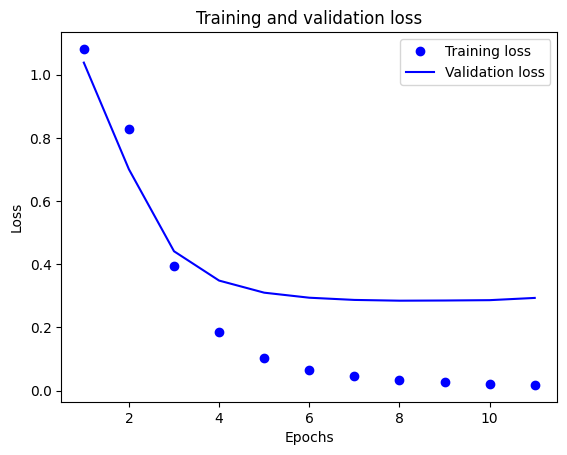

38/38 [==============================] - 0s 2ms/step - loss: 0.2846 - accuracy: 0.9116
Accuracy: 91.16%


In [41]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
import keras

model1 = Sequential()

# especificamos la longitud máxima de entrada en nuestra capa de embedding
model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))

# aplanamos el tensor 3D de embeddings en un tensor de dos dimensiones con la forma: max_words, max_comment_length * emdebbing_dim
model1.add(Flatten())

# añadimos el clasificador
model1.add(Dense(3, activation='softmax')) # uso la función "softmax" ya que estamos haciendo un modelo de clasificación multiclase

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # usamos esta función de pérdida porque funciona mejor para el problema que queremos solucionar (clasificación multiclase)
model1.summary()

# añadimos el early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True,
)

# entrenamos el modelo
history = model1.fit(x_train, y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    verbose = 0,
                    callbacks=[early_stopping],
                    validation_data=(x_val, y_val_one_hot))

# dibujamos las curvas de aprendizaje

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

score1 = model1.evaluate(x_val, y_val_one_hot)

print("Accuracy: %.2f%%" % (score1[1]*100))

<Figure size 640x480 with 0 Axes>

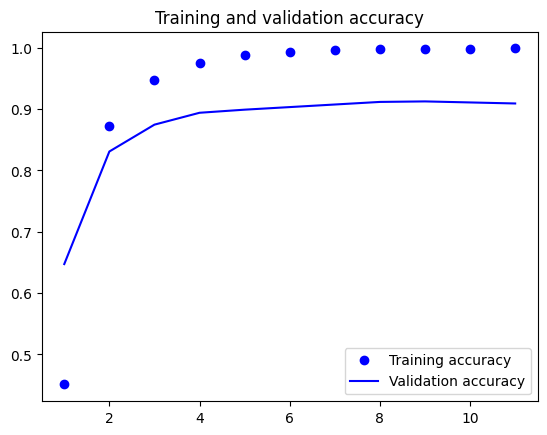

<Figure size 640x480 with 0 Axes>

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

Usando solo una capa y sin embeddings pre-entrenados ya hemos alcanzado una accuracy del 91.16%, que es casi igual a la accuracy del mejor modelo que hice la semana anterior.

## GloVe Embeddings

In [50]:
# descargar los GloVe Embeddings
import os
import numpy as np

glove_dir = '/content/drive/MyDrive/Colab Notebooks/EALC/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [51]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## Modelo 2: embeddings pre-entrenados congelados

In [54]:
# definimos el modelo

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 19, 50)            441700    
                                                                 
 flatten_14 (Flatten)        (None, 950)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 2853      
                                                                 
Total params: 444553 (1.70 MB)
Trainable params: 444553 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# cargamos los embeddings de GloVe en el modelo
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False # congelamos la capa de embeddings

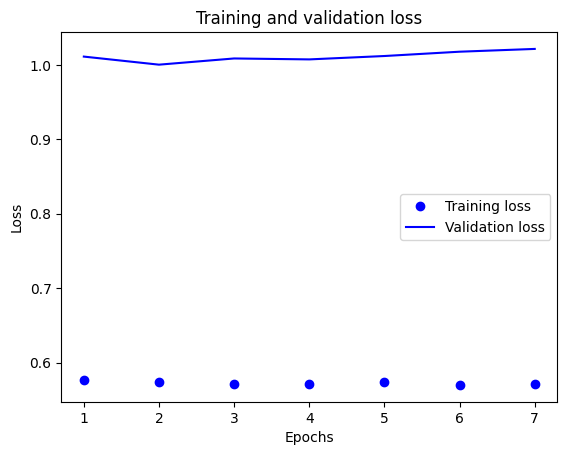

38/38 [==============================] - 0s 2ms/step - loss: 1.0003 - accuracy: 0.6465
Accuracy: 64.65%


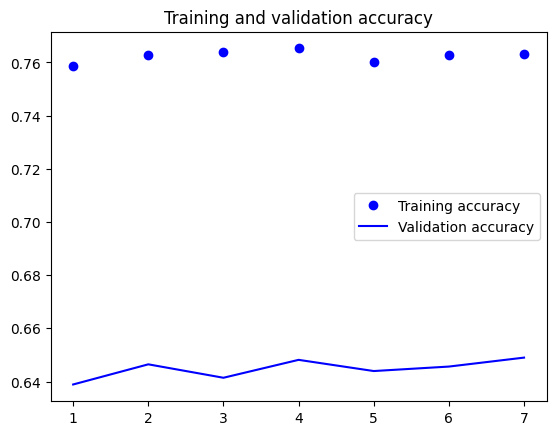

<Figure size 640x480 with 0 Axes>

In [61]:
# compilamos el modelo
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# añadimos el early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# entrenamos el modelo
history2 = model2.fit(x_train, y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    verbose = 0,
                    callbacks=[early_stopping],
                    validation_data=(x_val, y_val_one_hot))

# dibujamos las curvas de aprendizaje

import matplotlib.pyplot as plt

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

score2 = model2.evaluate(x_val, y_val_one_hot)
print("Accuracy: %.2f%%" % (score2[1]*100))


No quiero cambiar los parámetros porque quiero que la comparación entre modelos sea lo mejor posible. Sin embargo, vemos que hay una bajada drástica en la accuracy con los embeddings pre-entrenados de un 91.16% hasta un 64.45%.

## Modelo 3: embeddings pre-entrenados sin congelar

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 19, 50)            441700    
                                                                 
 flatten_15 (Flatten)        (None, 950)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 2853      
                                                                 
Total params: 444553 (1.70 MB)
Trainable params: 444553 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


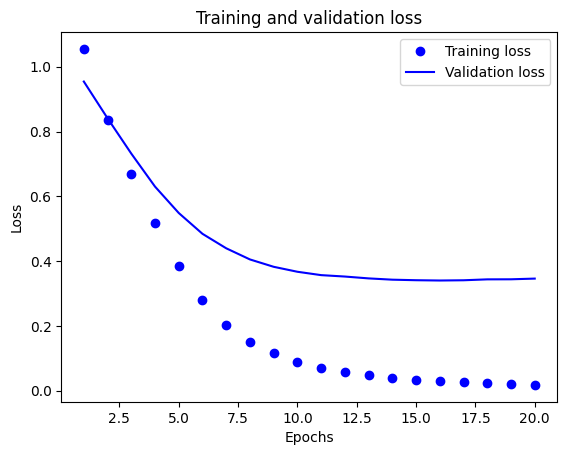

38/38 [==============================] - 0s 3ms/step - loss: 0.3408 - accuracy: 0.8897
Accuracy: 88.97%


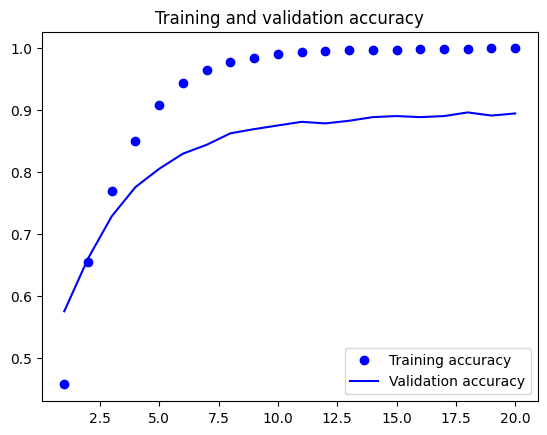

<Figure size 640x480 with 0 Axes>

In [63]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.summary()

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

# compilamos el modelo
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# añadimos el early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# entrenamos el modelo
history3 = model3.fit(x_train, y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    verbose = 0,
                    callbacks=[early_stopping],
                    validation_data=(x_val, y_val_one_hot))

# dibujamos las curvas de aprendizaje

import matplotlib.pyplot as plt

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

score3 = model3.evaluate(x_val, y_val_one_hot)
print("Accuracy: %.2f%%" % (score3[1]*100))


### Resumen de resultados

In [64]:
print("Sin word embeddings pre-entrenados")
print("Accuracy: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Accuracy: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Accuracy: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Accuracy: 91.16%
Con word embeddings pre-entrenados congelados
Accuracy: 64.56%
Con word embeddings pre-entrenados sin congelar
Accuracy: 88.97%


La conclusión que sacamos de estos resultados es que para nuestro dataset en particular, el modelo que mejor funciona es el que usa embeddings que no han sido pre-entrenados. Para hacer esta comparación, he usado los mismos parámetros en los tres modelos para poder obtener unos resultados más representativos de su funcionamiento. Sorprendentemente, los embeddings pre-entrenados congelados han sido muy contraproducentes, no han mejorado nuestra accuracy, sino que por el contrario, el resultado de usar los embeddings de GloVo congelados produjo una caída de casi el 30% en la precisión del modelo. Esto se explica porque mi dataset no es especialmente grande y al congelar los pesos de los embeddings de GloVo y que no se actualicen durante el entrenamiento, hace que sea muy dificil que unos embeddings diseñados de manera muy general, puedan funcionar de manera eficiente para una tarea tan específica como esta: clasificar textos en tres emociones concretas. Afortunadamente, los resultados mejoran notablemente cuando no congelamos la capa de embeddings. Pero aún así, sigue sin superar la accuracy obtenida por el primer modelo usando la capa de embedding de Keras. Tiene sentido que en este caso la técnica más eficaz sea crear nuestros propios embeddings de palabras diseñados específicamente para resolver este problema.